In [228]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [229]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [230]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [231]:
DIR_DATA  = '../input/diploma/'

In [232]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

In [233]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [234]:
data_d.loc[56]['homeFacts']

"{'atAGlanceFacts': [{'factValue': '1998', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': 'No Info', 'factLabel': 'Price/sqft'}]}"

# Анализ целевой переменной.

# Вспомогательная функция извлечения числа из записи доллара.

In [235]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [236]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [237]:
data_d['target'].isna().unique()

array([False,  True])

In [238]:
data_d.loc[data_d['target'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
61,NaN,NaN,Single Family,7353 Boysenberry Ct,2.0,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",Yes,Jacksonville,"[{'rating': ['7/10', '2/10', '4/10'], 'data': ...","1,446 sqft",32244,3,FL,1,NaN,NaN,NaN,NaN
94,Pre-foreclosure / auction,NaN,Townhouse,20663 Fm 2154 Rd,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Yes,College Station,"[{'rating': ['NA', '2/10', 'NA'], 'data': {'Di...","Total interior livable area: 4,179 sqft",77845,4 bd,TX,2.0,NaN,NaN,NaN,NaN
121,/ auction,NaN,Single Family,3719 Suffolk St,2,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",Yes,Durham,"[{'rating': ['2/10', '5/10', '4/10'], 'data': ...","2,327",27707,3,NC,0.0,NaN,NaN,NaN,NaN
169,NaN,NaN,Single Family,8201 Waterford Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",NaN,Tamarac,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...","1,280 sqft",33321,2,FL,1.0,NaN,NaN,NaN,NaN
174,Pre-foreclosure / auction,NaN,Single Family,17508 Puritas Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Cleveland,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...","Total interior livable area: 1,209 sqft",44135,2 bd,OH,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376495,recently sold,NaN,single-family home,7433 Creekland Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Reno,"[{'rating': ['None/10', '5/10', '3/10'], 'data...","1,082 sqft",89506,2 Beds,NV,1,NaN,NaN,NaN,NaN
376528,foreclosure,NaN,apartment,5652 S Justine St,2 Baths,"{'atAGlanceFacts': [{'factValue': '2009', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '1/10', '2/10'], 'data': ...","2,351 sqft",60636,6 Beds,IL,NaN,NaN,NaN,NaN,NaN
376577,Foreclosed,NaN,Single Family,1851 W Landstreet Rd # 3233,NaN,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...",NaN,Orlando,"[{'rating': ['4/10', '2/10', '5/10'], 'data': ...",Total interior livable area: 620 sqft,32809,-- bd,FL,NaN,NaN,NaN,NaN,NaN
376937,NaN,NaN,NaN,8501 NW 53rd Ter,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",NaN,33166,1.74 acres,FL,NaN,NaN,NaN,NaN,NaN


In [239]:
data_d.dropna(axis=0,subset=['target'],inplace=True)

In [240]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

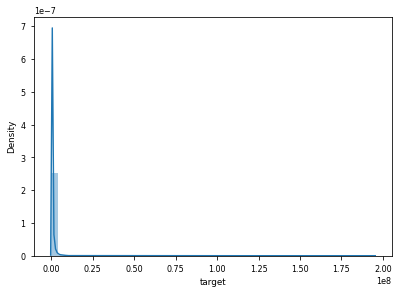

In [241]:
sns.distplot(data_d['target'])

# Удаление выбросов в целевой переменной.

In [242]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [243]:
data_d['target'].mean()

644757.5030263888

In [244]:
#data_d.loc[data_d['target']>data_d['target'].mean()]

In [245]:
#data_d.loc[data_d['target']>500000]

In [246]:
#data_d = data_d[(data_d['target'] < 550000)]

In [247]:
data_d.target = np.log(data_d.target[data_d.target > 0])

<AxesSubplot:xlabel='target', ylabel='Density'>

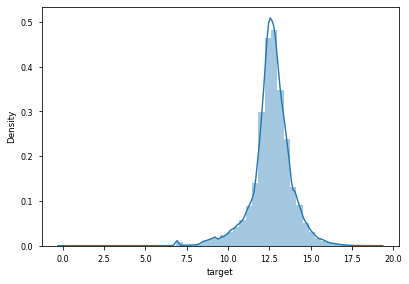

In [248]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fda7619ad90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fda6218e150>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fda7619add0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fda7619ab50>}

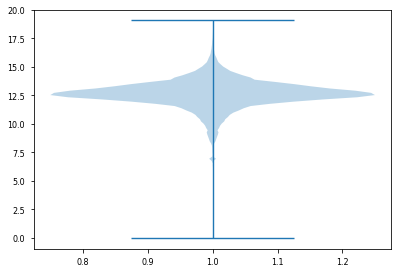

In [249]:
plt.violinplot(data_d['target'])

In [250]:
data_d['target'].isna().unique()

array([False])

In [251]:
data_d.loc[data_d['target']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 15533 to 321515
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        13 non-null     object 
 1   private pool  0 non-null      object 
 2   propertyType  14 non-null     object 
 3   street        15 non-null     object 
 4   baths         7 non-null      object 
 5   homeFacts     15 non-null     object 
 6   fireplace     8 non-null      object 
 7   city          15 non-null     object 
 8   schools       15 non-null     object 
 9   sqft          13 non-null     object 
 10  zipcode       15 non-null     object 
 11  beds          9 non-null      object 
 12  state         15 non-null     object 
 13  stories       6 non-null      object 
 14  mls-id        0 non-null      object 
 15  PrivatePool   0 non-null      object 
 16  MlsId         15 non-null     object 
 17  target        15 non-null     float64
dtypes: float64(1), object(17

In [253]:
data_d = data_d.drop(data_d[data_d['target']==0].index)

In [26]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [255]:
data_d['target'].isna().unique()

array([False])

# Обработка признака homeFacts.

In [256]:
def facts_extraction(slovar):
    if slovar.find('atAGlanceFacts')>-1:
        slovar1 = eval(slovar)
       # print(type(slovar1))
        #print(slovar1)
        slovar2=slovar1.get('atAGlanceFacts')
       # print(type(slovar2))
       # print(slovar2)
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN


In [257]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))
t = data_d['homeFacts']
t_lst = t.tolist()
columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']
t1 = pd.DataFrame(t_lst, columns = columns)
data_d = data_d.join(t1)

In [258]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374689 entries, 0 to 377184
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335434 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340136 non-null  object 
 3   street          374687 non-null  object 
 4   baths           269321 non-null  object 
 5   homeFacts       374689 non-null  object 
 6   fireplace       102514 non-null  object 
 7   city            374655 non-null  object 
 8   schools         374689 non-null  object 
 9   sqft            334569 non-null  object 
 10  zipcode         374689 non-null  object 
 11  beds            283739 non-null  object 
 12  state           374689 non-null  object 
 13  stories         224904 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310211 non-null  object 
 17  target    

In [259]:
data_d['Remodeled year'].value_counts()

        197194
2006      5451
2005      4747
2007      4322
2008      3735
         ...  
1888         1
1800         1
1738         1
1869         1
1862         1
Name: Remodeled year, Length: 154, dtype: int64

In [260]:
data_d['Heating'].value_counts()

                                                                104451
Forced Air                                                       81795
Forced air                                                       50775
Other                                                            28898
Electric                                                         10101
                                                                 ...  
Natural Gas, Space Heater                                            1
Exhaust Fans                                                         1
Central, Exhaust Fans, Natural Gas, Zoned                            1
BR Closet-Electric - new                                             1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor         1
Name: Heating, Length: 1975, dtype: int64

In [261]:
data_d['Cooling'].value_counts()

Central                                               156604
                                                      118783
Central Air                                            14290
No Data                                                10326
Has Cooling                                             9666
                                                       ...  
Heat Pump - AC, Propane                                    1
Central Gas, Propane, Zoned                                1
Other (See Remarks), Panel/Floor/Wall, Window Unit         1
Multi Units, Zoned Cooling                                 1
Central A/C (Gas), Central Heat (Gas), Heat Pump           1
Name: Cooling, Length: 1440, dtype: int64

In [262]:
data_d['Parking'].value_counts()

                                                                                                                                    169868
Attached Garage                                                                                                                      69796
2 spaces                                                                                                                             27660
1 space                                                                                                                              14025
Detached Garage                                                                                                                      13008
                                                                                                                                     ...  
Electric Door Opener, Tandem Garage, RV Gate, Dir Entry frm Garage, Slab Parking Spaces                                                  1
Electric Door Opener, Extnd

In [263]:
data_d.head(30)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,12.943237,2019,,"Central A/C, Heat Pump",,,None,$144
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"[2019, , , , , 5828 sqft, $159/sqft]",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,12.644328,2019,,,,,5828 sqft,$159/sqft
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"[1961, 1967, Forced Air, Central, Attached Gar...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,14.878496,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"[2006, 2006, Forced Air, Central, Detached Gar...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,14.688894,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,8.517193,,,,,,"10,019 sqft",None
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"[1920, , Forced Air, Central, , 680 sqft, $233...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,12.250090,1920,,Forced Air,Central,,680 sqft,$233/sqft
6,Active,NaN,Florida,552 Casanova Ct,NaN,"[2006, 2006, Electric, Heat Pump, Central Air,...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,NaN,NaN,S5026943,12.109011,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"[1976, , , , , 8,750 Sq. Ft., $57 / Sq. Ft.]",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,11.127263,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"[1970, , Forced Air, Central, , 124582, $68]",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,3,IA,NaN,NaN,NaN,190988,12.408605,1970,,Forced Air,Central,,124582,$68
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"[2019, None, Gas, Central, Attached Garage, 2,...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,12.650742,2019,None,Gas,Central,Attached Garage,"2,056 sqft",$162


# Разбор признака школы.

In [264]:
data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))
t = data_d['schools']
t_lst = t.tolist()
t5_lst = []
for i in t_lst:
    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
    t5_lst.append(i1)

df_lst = pd.DataFrame(t5_lst,dtype=str)
data_d = data_d.join(df_lst)

In [265]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374689 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335434 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340136 non-null  object 
 3   street          374687 non-null  object 
 4   baths           269321 non-null  object 
 5   homeFacts       374689 non-null  object 
 6   fireplace       102514 non-null  object 
 7   city            374655 non-null  object 
 8   schools         374689 non-null  object 
 9   sqft            334569 non-null  object 
 10  zipcode         374689 non-null  object 
 11  beds            283739 non-null  object 
 12  state           374689 non-null  object 
 13  stories         224904 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310211 non-null  object 
 17  target    

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [266]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [267]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [268]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [269]:
data_d.loc[data_d['sqft'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,8.517193,,,,,,"10,019 sqft",None,"['4/10', '5/10', '5/10']","['5.96mi', '3.25mi', '3.03mi']","['7-8', '9-12', 'PK-6']","['Southwest Middle School', 'Bayside High Scho..."
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"[1976, , , , , 8,750 Sq. Ft., $57 / Sq. Ft.]",NaN,Memphis,"{'rating': ['4', '2', '2'], 'data': {'Distance...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,11.127263,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid..."
15,New,NaN,2 Story,930 52nd St,NaN,"[1905, 1905, , Steam Heating, , 2,003 Sq. Ft.,...",NaN,Brooklyn,"{'rating': ['8', '8', '3'], 'data': {'Distance...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,14.316286,1905,1905,,Steam Heating,,"2,003 Sq. Ft.",None,"['8', '8', '3']","['0.2 mi', '0.2 mi', '1.5 mi']","['K to 5', '6 to 8', '9 to 12']","['PS 160 William T Sampson', 'Junior High Scho..."
26,Active,NaN,NaN,5755 SW 123 Ave,"1,000","[, , , , , —, None]",NaN,Miami,"{'rating': ['9', '10', 'NR', '6', '3'], 'data'...",NaN,33183,Baths,FL,NaN,NaN,NaN,A10787617,13.591116,,,,,,—,None,"['9', '10', 'NR', '6', '3']","['1.0 mi', '13.7 mi', '7.9 mi', '0.9 mi', '1.2...","['Preschool to 5', 'Preschool to 8', 'K to 9',...","['Royal Green Elementary School', 'Air Base El..."
40,Active,NaN,NaN,1104 Rotonda Cir,NaN,"[, , , , , —, None]",NaN,ROTONDA WEST,"{'rating': ['6', '6', '7'], 'data': {'Distance...",NaN,33947,NaN,FL,NaN,NaN,NaN,D6107075,10.896739,,,,,,—,None,"['6', '6', '7']","['3.1 mi', '3.2 mi', '5.6 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Vineland Elementary School', 'L. A. Ainger M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377141,Active,NaN,NaN,Mantova Ct,NaN,"[, , , , , —, None]",NaN,ORLANDO,"{'rating': ['7', '6', 'NR', 'NR', '7'], 'data'...",NaN,32836,NaN,FL,NaN,NaN,NaN,O5763033,12.899220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377146,for sale,NaN,single-family home,206/208 N Randolph St,NaN,"[1910, , , , , 5488 sqft, None]",NaN,Indianapolis,"{'rating': ['1/10'], 'data': {'Distance': ['0....",NaN,46201,NaN,IN,NaN,NaN,NaN,21686741,10.819778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377154,Active,NaN,NaN,2104 Russell Ave,NaN,"[, , , , , 6,970 Sq. Ft., None]",NaN,Charlotte,"{'rating': ['2', '3', '3'], 'data': {'Distance...",NaN,28216,NaN,NC,NaN,NaN,NaN,3571015,11.512825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377161,Active,NaN,Land,Homestead Dr Lot 1,NaN,"[, , , , , 1, None]",NaN,Columbiana,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",NaN,44408,NaN,OH,NaN,NaN,NaN,3382834,10.714418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
data_d[['sqft']] = data_d[['sqft']].fillna(method='ffill')

In [271]:
data_d['sqft'].isna().sum()

0

In [272]:
data_d.loc[data_d['sqft'].min()]

status                                                     for sale
private pool                                                    NaN
propertyType                                     single-family home
street                                            12911 E Heroy Ave
baths                                                       3 Baths
homeFacts                      [2019, , , , , 5828 sqft, $159/sqft]
fireplace                                                       NaN
city                                                 Spokane Valley
schools           {'rating': ['4/10', 'None/10', '4/10'], 'data'...
sqft                                                         1947.0
zipcode                                                       99216
beds                                                         3 Beds
state                                                            WA
stories                                                         2.0
mls-id                                          

<AxesSubplot:xlabel='sqft', ylabel='Density'>

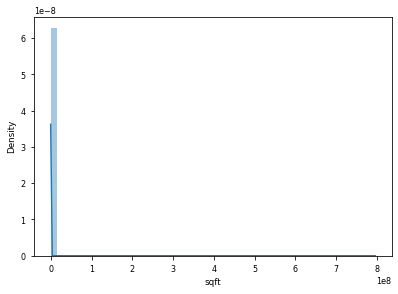

In [273]:
sns.distplot(data_d['sqft'])

In [274]:
data_d.loc[data_d['sqft'].median()]

status                                              Pre-foreclosure
private pool                                                    NaN
propertyType                                          Single Family
street                                               2297 Wander St
baths                                                  Bathrooms: 3
homeFacts           [2006, 2006, , , Attached Garage, 5,063 sqft, ]
fireplace                                                       NaN
city                                                    Chula Vista
schools           {'rating': ['9/10', '9/10', '9/10'], 'data': {...
sqft                                                         2361.0
zipcode                                                       91915
beds                                                           4 bd
state                                                            CA
stories                                                         NaN
mls-id                                          

In [275]:
data_d['sqft_big'] = data_d['sqft'].apply(lambda x: 1 if x > 2300 else 0)

In [276]:
data_d.sqft = data_d.sqft.apply(lambda x: 2301 if x>2300 else x)

# Визуализация признака площадь

<AxesSubplot:xlabel='sqft', ylabel='Density'>

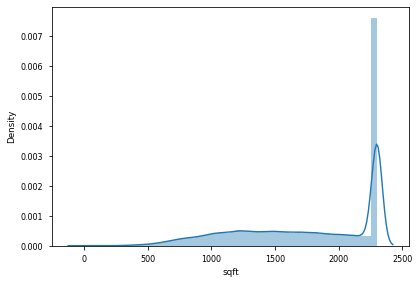

In [277]:
sns.distplot(data_d['sqft'])


Text(0.5, 1.0, 'Зависимость цены от площади')

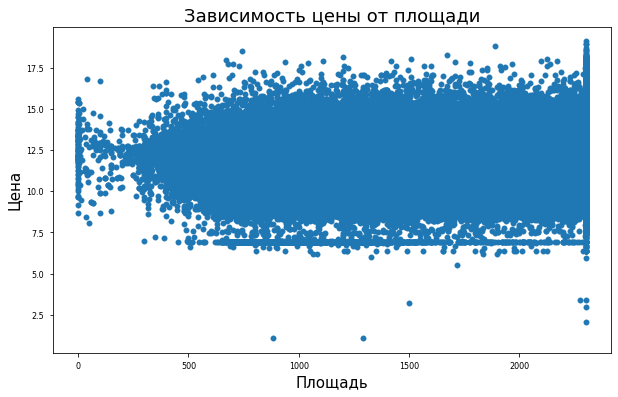

In [278]:
x = data_d['sqft']
y = data_d['target']
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

<AxesSubplot:xlabel='sqft'>

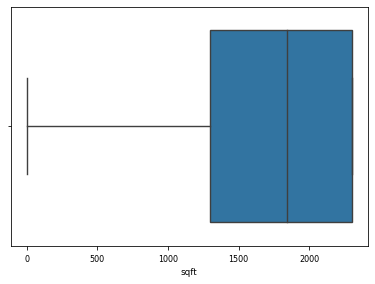

In [279]:
sns.boxplot(data_d['sqft'])

# Спальни - приведение к численному виду.

In [280]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"[1922, , , , , 1079000, None]",NaN,Falconer,"{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'data...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,11.277203,1981,,,,,,$485,"['7/10', '7/10', '6/10']","['0.3 mi', '1.1 mi', '1.1 mi']","['K-5', '6-8', '9-12']","['Pierpont Elementary School', 'Cabrillo Middl...",0


In [281]:
#data_d = data_d.drop(data_d['beds'] == '# Bedrooms 1st Floor')

Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [282]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [283]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [284]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1          211588
3 Beds      53073
4 Beds      35225
2 Beds      26196
3 bd        12678
            ...  
23 bd           1
31 Beds         1
27 bd           1
26 bd           1
88 Beds         1
Name: beds, Length: 74, dtype: int64

In [285]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big


Вспомогательная функция для выбора числового значения признака спальни.

In [286]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [287]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [288]:
data_d['beds'].unique()                        


array([ 1,  3,  5,  2,  4,  8,  6, 12,  7,  9, 16, 13, 18, 10, 20, 26, 64,
       22, 11, 24, 14, 28, 32, 15, 36, 19, 25, 17, 27, 47, 23, 44, 31, 34,
       78, 48, 40, 33, 53, 51, 30, 39, 42, 21, 52, 46, 76, 88])

In [289]:
data_d['beds'].isna().sum()

0

In [290]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374689 entries, 0 to 377184
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335434 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340136 non-null  object 
 3   street          374687 non-null  object 
 4   baths           269321 non-null  object 
 5   homeFacts       374689 non-null  object 
 6   fireplace       102514 non-null  object 
 7   city            374655 non-null  object 
 8   schools         374689 non-null  object 
 9   sqft            374689 non-null  float64
 10  zipcode         374689 non-null  object 
 11  beds            374689 non-null  int64  
 12  state           374689 non-null  object 
 13  stories         224904 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310211 non-null  object 
 17  target    

In [291]:
data_d.loc[data_d['beds']==10]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
2591,for sale,NaN,multi-family,3222 105th St,3 Baths,"[1930, 1930, , , Attached Garage, 2648 sqft, $...",NaN,East Elmhurst,"{'rating': ['3/10', '5/10', '5/10', '2/10'], '...",2301.0,11369,10,NY,NaN,NaN,NaN,3176232,14.252474,2003,None,Baseboard,Central,Attached Garage,None,$795,"['7/10', '9/10', '1/10']","['0.4 mi', '0.4 mi', '0.3 mi']","['K-5', '6-8', '9-12']","['Lincoln Elementary School', 'American Indian...",1
2964,For sale,NaN,Multi Family,2756 27th St # 6-FAMILY,Bathrooms: 6,"[1923, , , , , -- sqft lot, ]",NaN,Astoria,"{'rating': ['4/10', '6/10', '2/10'], 'data': {...",1290.0,11102,10,NY,NaN,NaN,NaN,NaN,14.552196,1969,1970,Forced Air,Central,Carport,"5,220 sqft",$188/sqft,"['3/10', '8/10', '4/10']","['2.12mi', '1.71mi', '1.61mi']","['9-12', 'PK-5', '6-8']","['Boyd H. Anderson High School', 'Pinewood Ele...",0
5835,foreclosure,NaN,multi-family,4128 W Wilcox St #1-4,8 Baths,"[2011, , , , , 3025 sqft, $37/sqft]",NaN,Chicago,"{'rating': ['1/10', '5/10', '4/10'], 'data': {...",2301.0,60624,10,IL,NaN,NaN,NaN,10420955,12.100156,2019,,Forced Air,Central,,,None,"['3/10', '4/10', '3/10']","['2.73mi', '3.53mi', '1.92mi']","['9-12', '6-8', 'PK-5']","['Hallandale High School', 'Olsen Middle Schoo...",1
8023,for sale,NaN,multi-family,2424 Raymond Ave,10 Baths,"[1924, , Gas, None, , 6,750 sqft, $426/sqft]",NaN,Los Angeles,"{'rating': ['4/10', '4/10'], 'data': {'Distanc...",2301.0,90007,10,CA,2.0,NaN,NaN,19520840,14.508658,2001,,Central Air Conditioning,"Gas Heating, Forced Air Heating",,"8,770 Sq. Ft.",$111 / Sq. Ft.,"['NR', '8', '7', '8']","['1.4 mi', '1.2 mi', '1.3 mi', '3.3 mi']","['K to 2', '3 to 5', '6 to 8', '9 to 12']","['MacKeben Elementary School', 'Conley Element...",1
10337,for sale,NaN,multi-family,3755 S Canfield Ave,7 Baths,"[1962, , , , Attached Garage, 6,760 sqft, $329...",NaN,Los Angeles,"{'rating': ['7/10', '6/10', '3/10'], 'data': {...",2301.0,90034,10,CA,NaN,NaN,NaN,19528126,15.024172,2020,,Electric Heat,Central Heating,,—,$245 / Sq. Ft.,"['4', 'NR', 'NR', '7', '2']","['0.5 mi', '0.2 mi', '0.3 mi', '0.5 mi', '1.8 ...","['Preschool to 8', 'Preschool to 8', 'Preschoo...","['Hawthorne Pk-8 Academy', 'San Antonio Academ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371632,for sale,NaN,multi-family,78-78A Mattapan St,8 Baths,"[1905, , Other, , Attached Garage, 2,500 sqft,...",NaN,Boston,"{'rating': [], 'data': {'Distance': [], 'Grade...",2301.0,2126,10,MA,3.0,NaN,NaN,72597290,13.815510,2005,,Forced Air,Central,2,"2,178 sqft",$145/sqft,"['None/10', '1/10', '4/10']","['0.57mi', '1.01mi', '0.44mi']","['6-8', 'K-5', '9-12']","['D C Virgo Middle School', 'Annie H Snipes El...",1
372938,for sale,NaN,multi-family,532 E 5th St #1,20 Baths,"[2012, , , , , , $957/sqft]",NaN,New York,"{'rating': ['6/10', '5/10', '6/10', 'None/10',...",2301.0,10009,10,NY,NaN,NaN,NaN,NaN,16.213406,2015,,,,,6098,$175,"['5', '5', '6', 'NR', 'NR', 'NR', 'NR', 'NR']","['1.6 mi', '3.9 mi', '0.4 mi', '0.9 mi', '1.0 ...","['K–6', '7–8', '9–12', 'PK–2', 'PK–12', '9–12'...","['Riverview Elementary School', 'Centennial Mi...",1
375309,for sale,NaN,multi-family,2129 N Latrobe Ave,4 Baths,"[1910, , Forced Air, , Detached Garage, , None]",NaN,Chicago,"{'rating': ['1/10', '1/10', '5/10'], 'data': {...",1603.0,60639,10,IL,NaN,NaN,NaN,10548543,12.762827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
376081,for sale,NaN,multi-family,8559 S Escanaba Ave,4 Baths,"[1915, , Gas, , 2, 3,000 sqft, None]",NaN,Chicago,"{'rating': ['2/10', '1/10'], 'data': {'Distanc...",2301.0,60617,10,IL,NaN,NaN,NaN,10539126,12.496875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [292]:
#data_d.loc[[data_d['beds'] == 10 & data_d['target']<150000]]

In [293]:
#data_d = data_d.drop(data_d[[data_d['beds'] == 10] & data_d[data_d['target']<150000]].index)

In [294]:
#data_d.loc[data_d['beds']==10]

# Визуализация и обработка признака спальни (beds).

In [295]:
data_d['beds_big']= data_d['beds'].apply(lambda x: 1 if x>7 else 0)

In [296]:
data_d.beds = data_d.beds.apply(lambda x: 11 if x>10 else x)

In [297]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374689 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335434 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340136 non-null  object 
 3   street          374687 non-null  object 
 4   baths           269321 non-null  object 
 5   homeFacts       374689 non-null  object 
 6   fireplace       102514 non-null  object 
 7   city            374655 non-null  object 
 8   schools         374689 non-null  object 
 9   sqft            374689 non-null  float64
 10  zipcode         374689 non-null  object 
 11  beds            374689 non-null  int64  
 12  state           374689 non-null  object 
 13  stories         224904 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310211 non-null  object 
 17  target    

In [298]:
data_d['beds'].isna().sum()

0

<AxesSubplot:xlabel='beds', ylabel='Density'>

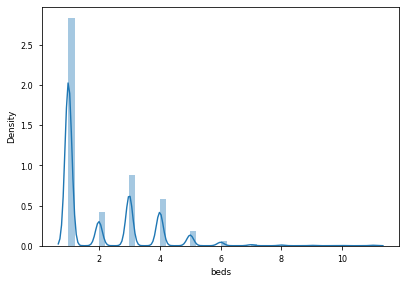

In [299]:
sns.distplot(data_d['beds'])

In [300]:
y = data_d['target']

In [301]:
x = data_d['beds']

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

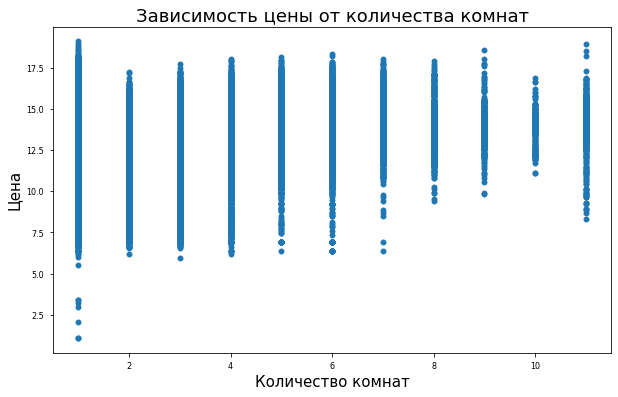

In [302]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)


<AxesSubplot:xlabel='beds'>

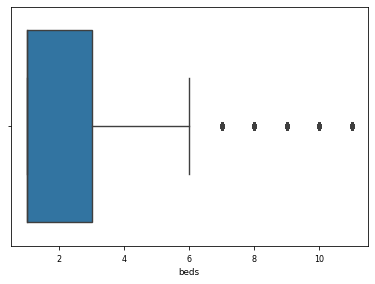

In [303]:
sns.boxplot(data_d['beds'])

# Ванны - приведение к численному виду.

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [304]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [305]:
data_d.baths = data_d.baths.apply(lambda x: round(main_extract_num(str(x)),1))

In [306]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 2.00e+00, 8.00e+00, 1.00e+00, 4.00e+00,
       5.00e+00, 7.00e+00, 2.10e+00, 2.50e+00, 4.50e+00, 6.00e+00,
       5.50e+00, 1.50e+00, 0.00e+00, 9.00e+00, 1.20e+01, 7.50e+02,
       1.00e+01, 1.90e+01, 7.50e+00, 1.80e+01, 1.10e+01, 1.80e+00,
       6.50e+00, 1.60e+01, 1.30e+01, 1.40e+01, 8.50e+00, 1.10e+00,
       1.70e+01, 2.41e+02, 1.05e+01, 2.00e+01, 4.00e+01, 2.80e+00,
       2.40e+01, 2.20e+01, 2.20e+00, 3.10e+00, 3.20e+00, 3.20e+01,
       2.70e+01, 2.60e+01, 9.50e+00, 1.50e+01, 3.50e+01, 3.80e+00,
       2.90e+01, 1.16e+02, 2.10e+01, 5.20e+00, 1.45e+01, 7.60e+01,
       2.30e+01, 4.30e+01, 1.20e+00, 3.40e+01, 5.50e+01, 2.50e+01,
       1.25e+01, 4.40e+01, 5.00e-01, 4.20e+00, 4.80e+00, 8.00e-01,
       4.10e+00, 4.10e+01, 3.60e+01, 3.00e+01, 2.80e+01, 6.40e+01,
       1.15e+01, 3.90e+01, 4.20e+01, 6.00e+01, 6.80e+00, 6.80e+01])

In [307]:
data_d['baths'].isna().sum()

0

In [308]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374689 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335434 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340136 non-null  object 
 3   street          374687 non-null  object 
 4   baths           374689 non-null  float64
 5   homeFacts       374689 non-null  object 
 6   fireplace       102514 non-null  object 
 7   city            374655 non-null  object 
 8   schools         374689 non-null  object 
 9   sqft            374689 non-null  float64
 10  zipcode         374689 non-null  object 
 11  beds            374689 non-null  int64  
 12  state           374689 non-null  object 
 13  stories         224904 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310211 non-null  object 
 17  target    

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

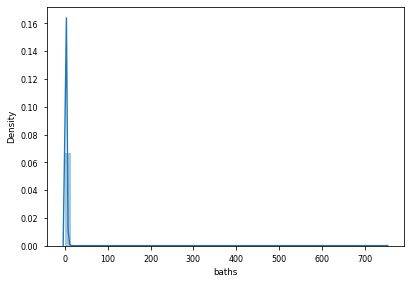

In [309]:
sns.distplot(data_d['baths'])

In [310]:
data_d.loc[data_d['baths']>10]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
459,for sale,NaN,single-family home,943 Konga Dr,12.0,"[2010, 2010, Forced Air, Central, Attached Gar...",yes,Las Vegas,"{'rating': ['7/10', '5/10', 'None/10'], 'data'...",2301.0,89123,9,NV,2.0,NaN,yes,2063700,15.068274,1895,,,,Detached Garage,"2,952 sqft",None,"['1/10', '1/10', '3/10']","['1.2mi', '8.76mi', '0.19mi']","['9-12', '9-12', 'PK-8']","['Orr Academy High School', 'Hope College Prep...",1,1
1109,Active,NaN,"Attached or 1/2 Duplex, Traditional",3624 Douglas Ave,750.0,"[1993, 1993, , Central A/C (Electric), Central...",1,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",1758.0,75219,1,TX,NaN,NaN,NaN,14240509,13.120361,1963,1964,Forced Air,Central,,,$221/sqft,"['10/10', '7/10', '5/10']","['2.3mi', '2.75mi', '2.32mi']","['K-5', '9-12', '6-8']","['Bayview Elementary School', 'Fort Lauderdale...",0,0
1349,For sale,NaN,Multi Family,1501 1503 1513 S Walnut St # 106,19.0,"[1920, , Gas, Central, 19 spaces, 6 acres lot,...",NaN,Bloomington,"{'rating': ['7/10', '6/10'], 'data': {'Distanc...",2301.0,47401,11,IN,2.0,201931321,NaN,NaN,14.220976,1952,1982,Baseboard,Central,Attached Garage,0.44 acres,$255/sqft,"['None/10', '9/10', '9/10', '9/10']","['1.6mi', '0.36mi', '0.71mi', '0.69mi']","['PK-2', '3-5', '9-12', '6-8']","['Goldwood Primary Elementary School', 'Kensin...",1,1
1727,For sale,NaN,Single Family,2890 Dudley Ave,12.0,"[1930, , Oil, , Carport, 2,374 sqft, $341]",NaN,Bronx,"{'rating': ['7/10', '3/10'], 'data': {'Distanc...",1726.0,10461,3,NY,NaN,QCZD7N,NaN,NaN,13.286181,2016,,,,,"7,560 sqft",$164/sqft,"['7/10', '7/10', '5/10']","['0.65mi', '5.98mi', '6.91mi']","['PK-6', '9-12', '6-8']","['John S. Wash Elementary School', 'Sanger Hig...",0,0
2022,Active,NaN,NaN,920 I St NW #411,750.0,"[2013, , , , , —, $1097 / Sq. Ft.]",NaN,Washington,"{'rating': ['8', '8', '3', '8'], 'data': {'Dis...",1367.0,20001,1,DC,NaN,NaN,NaN,DCDC449992,14.220309,2001,None,Forced air,Central,2 spaces,"7,405 sqft",$97,"['4/10', '3/10', '3/10']","['0.1 mi', '1.4 mi', '1.1 mi']","['PK-5', '6-8', '9-12']","['William Paschall Elementary School', 'Kirby ...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375634,Active,NaN,"Condo/Townhome, Contemporary/Modern",3225 Turtle Creek Blvd #1646,750.0,"[1998, 1998, , Central A/C (Electric), Central...",NaN,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",832.0,75219,1,TX,NaN,NaN,NaN,14215205,12.299108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376012,Active,NaN,"Condo/Townhome, Other (See Remarks)",2262 Alterbrook Ln,750.0,"[2019, , , Central A/C (Electric), Central Hea...",NaN,Dallas,"{'rating': ['4', '3', '2', '10'], 'data': {'Di...",2102.0,75219,1,TX,NaN,NaN,NaN,14204976,13.049578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376147,Active,NaN,"Condo/Townhome, Hi-Rise",3225 Turtle Creek Blvd #528,750.0,"[1998, 1998, , Central A/C (Electric), Central...",NaN,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",837.0,75219,1,TX,22,NaN,NaN,14222399,12.388394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376772,Active,NaN,"Condo/Townhome, Contemporary/Modern",3811 Throckmorton St,750.0,"[2015, 2015, , Central A/C (Electric), Central...",1,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",2301.0,75219,1,TX,NaN,NaN,NaN,14187254,13.527827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [311]:
data_d = data_d[data_d['baths']<10]

<AxesSubplot:xlabel='baths', ylabel='Density'>

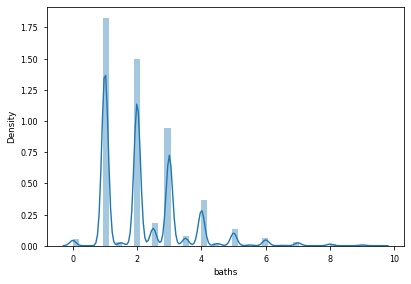

In [312]:
sns.distplot(data_d['baths'])

In [313]:
x = data_d['baths']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от оборудования ванн')

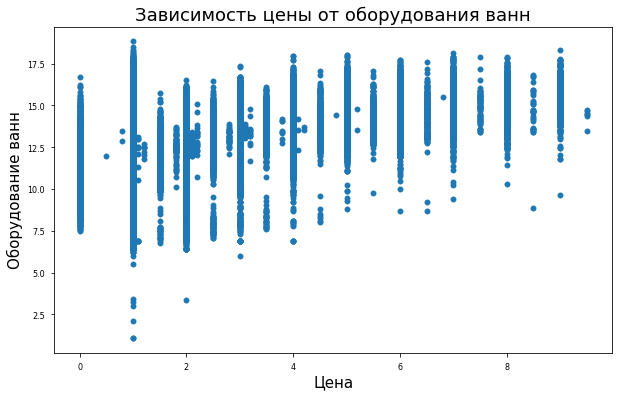

In [314]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Оборудование ванн', fontsize = 15)
plt.title('Зависимость цены от оборудования ванн', fontsize = 18)

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [315]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [316]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [317]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [318]:
data_d['fireplace'].isna().sum() 

0

In [319]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373433 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          334252 non-null  object 
 1   private pool    4126 non-null    object 
 2   propertyType    338928 non-null  object 
 3   street          373431 non-null  object 
 4   baths           373433 non-null  float64
 5   homeFacts       373433 non-null  object 
 6   fireplace       373433 non-null  int64  
 7   city            373399 non-null  object 
 8   schools         373433 non-null  object 
 9   sqft            373433 non-null  float64
 10  zipcode         373433 non-null  object 
 11  beds            373433 non-null  int64  
 12  state           373433 non-null  object 
 13  stories         224149 non-null  object 
 14  mls-id          24862 non-null   object 
 15  PrivatePool     39701 non-null   object 
 16  MlsId           309071 non-null  object 
 17  target    

In [320]:
x = data_d['fireplace']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

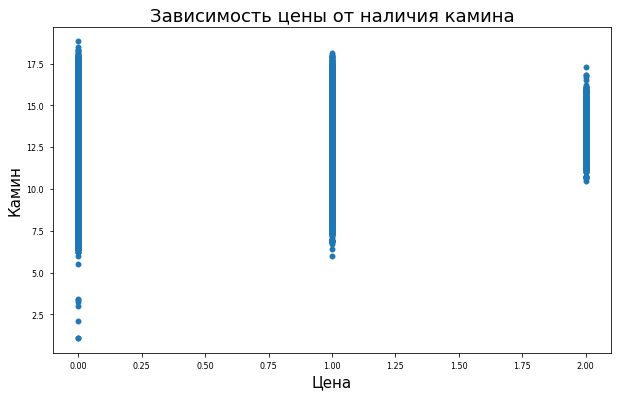

In [321]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Камин', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

# Бассейн. Анализ.

In [322]:
data_d['private pool'].value_counts()

Yes    4126
Name: private pool, dtype: int64

In [323]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"[1958, 1980, Heat pump, Central, 1 space, 0.45...",1,Tallahassee,"{'rating': ['4/10', '5/10', '7/10'], 'data': {...",2301.0,32308,3,FL,NaN,302221,NaN,NaN,12.860999,2019,,Central,Electric,,—,$258 / Sq. Ft.,"['9', '8', '9']","['5.0 mi', '7.1 mi', '7.7 mi']","['K to 5', '6 to 8', '9 to 12']","['Grassland Elementary School', 'Grassland Mid...",1,0
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"[2017, , Forced air, Central, 2 spaces, 3,484 ...",0,Riverside,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",2135.0,92503,3,CA,2.0,IV19242188,NaN,NaN,13.171154,1913,,Forced Air Heating,Central A/C,"Asphalt Driveway, Off Street",1720,$392,"['7', '4', '3', '6', '4', '6', 'NR', 'NR']","['0.1 mi', '0.8 mi', '0.9 mi', '0.5 mi', '0.4 ...","['PK–8', '6–6', '9–12', 'PK–8', '6–8', '9–12',...","['Truesdell Education Campus School', 'MacFarl...",0,0
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"[1976, , Forced air, Central, 2 spaces, -- sqf...",0,Escondido,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",1536.0,92026,2,CA,0.0,190034991,NaN,NaN,11.686879,,,,,,15960,None,"['2', '1', '3', '3', '2', 'NR', 'NR', 'NR']","['1.2 mi', '2.6 mi', '8.0 mi', '1.9 mi', '8.3 ...","['PK–4', '5–8', 'PK–12', 'PK–4', '6–8', '10–12...","['Laurel Elementary School', 'Lake Marion Cree...",0,0
404,For sale,Yes,Single Family,24448 Epson Ct,3.0,"[1987, , Forced air, Central, 3 spaces, 1.15 a...",0,Murrieta,"{'rating': ['7/10', '6/10', '8/10'], 'data': {...",1832.0,92562,3,CA,1.0,SW19240910,NaN,NaN,13.709038,2006,,Forced Air,Central,,"1,999 sqft",$89/sqft,"['2/10', '2/10', '3/10']","['2.64mi', '0.54mi', '0.57mi']","['9-12', 'PK-5', '6-8']","['Banneker High School', 'Bethune Elementary S...",0,0
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"[1964, 1964, Forced air, Central, , 8,624 sqft, ]",1,Jacksonville,"{'rating': ['5/10', '2/10', '4/10'], 'data': {...",1245.0,32221,3,FL,1.0,NaN,NaN,NaN,11.760590,1986,,,,,—,None,"['4', '3', '5', '10', '3']","['0.7 mi', '4.1 mi', '0.8 mi', '7.3 mi', '1.8 ...","['K to 5', 'K to 5', '6 to 8', '6 to 12', '9 t...","['Sunrise Elementary School', 'Thacker Avenue ...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376627,For sale,Yes,Cooperative,1201 S Riverside Dr Phb # PHB,2.0,"[1963, , Electric, Central, , -- sqft lot, $270]",0,Pompano Beach,"{'rating': ['6/10', '4/10', '3/10'], 'data': {...",2200.0,33062,3,FL,4.0,F10163349,NaN,NaN,13.296317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"[1979, 1979, Forced air, Central, 2 spaces, 7,...",0,Ontario,"{'rating': ['7/10', '6/10', '5/10'], 'data': {...",1726.0,91761,3,CA,2.0,IV19252050,NaN,NaN,13.079456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376694,For sale,Yes,Condo,5980 Shore Blvd S APT 312,3.0,"[1972, 1981, Forced air, Central, 1 space, -- ...",0,Gulfport,"{'rating': ['2/10', '2/10', '4/10'], 'data': {...",2210.0,33707,2,FL,9.0,U8064383,NaN,NaN,12.983101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376853,For sale,Yes,Townhouse,3188 NE Oregon St,4.0,"[2019, 2019, Forced air, Central, 2 spaces, --...",1,Portland,"{'rating': ['9/10', '7/10'], 'data': {'Distanc...",2301.0,97232,4,OR,3.0,19591180,NaN,NaN,13.422320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [324]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.268674
Single Family                                                  0.181873
Single Family Home                                             0.093512
condo                                                          0.076288
lot/land                                                       0.060567
                                                                 ...   
Contemporary, Farmhouse                                        0.000003
Contemporary, Modernist, Ranch, Rustic                         0.000003
1 Story, Contemporary, Traditional, Mediterranean              0.000003
A-Frame, Victorian/Federal                                     0.000003
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000003
Name: propertyType, Length: 1267, dtype: float64

In [325]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [326]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [327]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [328]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [329]:
data_d['propertyType'].value_counts()

other      284779
condo       50790
twnh        18452
mlf         12102
ctmp         4355
sn_dtch      2855
eng            55
loft           45
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [330]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes
data_d['propertyType_cat'] = data_d['propertyType_cat'].astype('category')

In [331]:
data_d['propertyType_cat'].isna().sum() 

0

In [332]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373433 entries, 0 to 377184
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            334252 non-null  object  
 1   private pool      4126 non-null    object  
 2   propertyType      373433 non-null  category
 3   street            373431 non-null  object  
 4   baths             373433 non-null  float64 
 5   homeFacts         373433 non-null  object  
 6   fireplace         373433 non-null  int64   
 7   city              373399 non-null  object  
 8   schools           373433 non-null  object  
 9   sqft              373433 non-null  float64 
 10  zipcode           373433 non-null  object  
 11  beds              373433 non-null  int64   
 12  state             373433 non-null  object  
 13  stories           224149 non-null  object  
 14  mls-id            24862 non-null   object  
 15  PrivatePool       39701 non-null   object  
 16  Ml

In [333]:
x = data_d['propertyType_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от типа собственности')

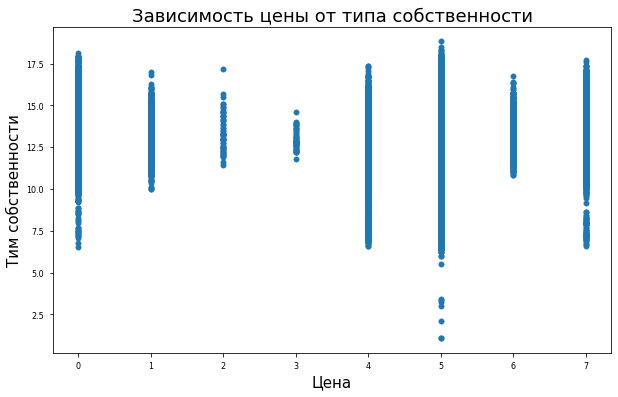

In [334]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Тим собственности', fontsize = 15)
plt.title('Зависимость цены от типа собственности', fontsize = 18)

# Город

In [335]:
data_d.city.fillna('others',inplace=True)

In [336]:
data_d['city'].isna().sum()

0

In [337]:
t = data_d['city'].value_counts()

In [338]:
t_df = pd.DataFrame(t)

In [339]:
t_df.loc[t_df['city']==np.NaN]

,city


In [340]:
t_df['city'].isna().sum()

0

In [341]:
dict_t = t_df.to_dict()

In [342]:
dict_city = dict_t.get('city')

In [343]:
data_d['city'].isna().sum()

0

Вспомогательная функция присваивает значение others, если число вхождений данного города невелико. (Здесь меньше 500.)

In [344]:
def other_cities(x1,d):
    if x1==np.NaN:
        return ('others')
    elif d.get(x1)==np.NaN:
        return('others')
    elif d.get(x1)<500: return ('others')
    else: return(x1)


In [345]:
data_d.city = data_d.city.apply(lambda x: other_cities(x,dict_city))

In [346]:
data_d.loc[data_d['city']=='others']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28387,1,NC,NaN,NaN,NaN,611019,12.943237,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3,WA,2.0,NaN,NaN,201916904,12.644328,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5
6,Active,NaN,other,552 Casanova Ct,1.0,"[2006, 2006, Electric, Heat Pump, Central Air,...",0,others,"{'rating': ['3', '3', '1', 'NR'], 'data': {'Di...",1507.0,34759,1,FL,One,NaN,NaN,S5026943,12.109011,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",0,0,5
8,Active,NaN,other,11182 Owl Ave,2.0,"[1970, , Forced Air, Central, , 124582, $68]",0,others,"{'rating': ['2', '2', '4', '7', '4', 'NR'], 'd...",2301.0,50401,1,IA,NaN,NaN,NaN,190988,12.408605,1970,,Forced Air,Central,,124582,$68,"['2', '2', '4', '7', '4', 'NR']","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']","['Roosevelt Elementary School', 'Lincoln Inter...",1,0,5
13,New construction,NaN,other,1538 Umpqua Dr,2.0,"[2019, 2019, Forced air, , Attached Garage, 7,...",0,others,"{'rating': ['7/10', '7/10', '8/10'], 'data': {...",1820.0,97401,3,OR,1.0,19221142,NaN,NaN,13.122163,2019,2019,Forced air,,Attached Garage,"7,000 sqft lot",$275,"['7/10', '7/10', '8/10']","['1.2 mi', '1.1 mi', '1 mi']","['K-5', '6-8', '9-12']","['Willagillespie Elementary School', 'Monroe M...",0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377134,New construction,NaN,condo,4282 Lahaina Dr,2.0,"[2019, None, Forced air, None, 3 spaces, None,...",0,others,"{'rating': ['9/10', '7/10', '9/10'], 'data': {...",1660.0,92649,1,CA,1,NaN,Yes,OC19273522,13.612024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
377140,for sale,NaN,other,6383 Cathedral Dr,1.0,"[, , , , , 3.34 acres, None]",0,others,"{'rating': ['5/10', '5/10', '7/10'], 'data': {...",2301.0,28601,1,NC,NaN,NaN,NaN,3525591,10.621327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,5
377147,Active,NaN,other,1022 Lyndon Station Dr,1.0,"[2020, , , Central Air, Gas (Hot Air), Multi-Z...",0,others,"{'rating': ['8', '4', '7'], 'data': {'Distance...",2058.0,28134,1,NC,NaN,NaN,NaN,3576461,12.745395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5
377161,Active,NaN,other,Homestead Dr Lot 1,1.0,"[, , , , , 1, None]",0,others,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",1323.0,44408,1,OH,NaN,NaN,NaN,3382834,10.714418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5


In [347]:
#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder(sparse=False)

In [348]:
#ohe_ftrs = ohe.fit_transform(data_d['city'].values.reshape(-1,1))

In [349]:
#tmp = pd.DataFrame(ohe_ftrs, columns = ['city=' + str(i) for i in range(ohe_ftrs.shape[1])])
#data_d = pd.concat([data_d, tmp], axis=1)


In [350]:
#data_d['city=97'].isna().sum()

In [351]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes
data_d['city_cat'] = data_d['city_cat'].astype('category')

<AxesSubplot:xlabel='city_cat', ylabel='Density'>

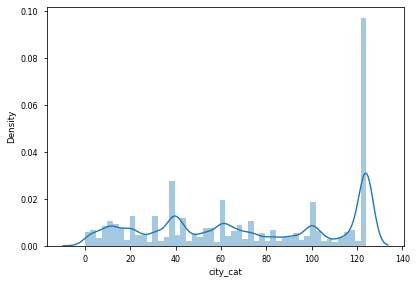

In [352]:
sns.distplot(data_d['city_cat'])

In [353]:
data_d['city_cat'].isna().sum()

0

In [354]:
x = data_d['city_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от города')

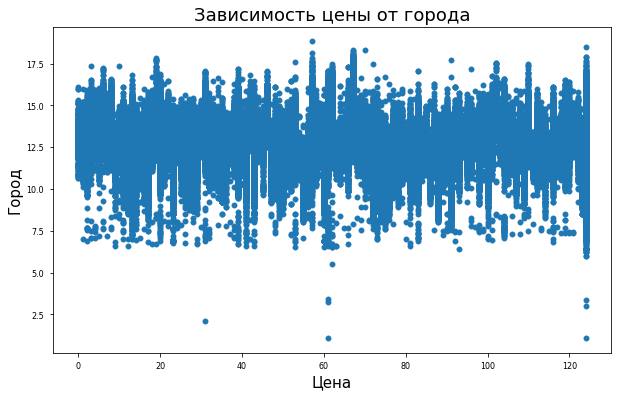

In [355]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Город', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

In [356]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373433 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            334252 non-null  object  
 1   private pool      4126 non-null    object  
 2   propertyType      373433 non-null  category
 3   street            373431 non-null  object  
 4   baths             373433 non-null  float64 
 5   homeFacts         373433 non-null  object  
 6   fireplace         373433 non-null  int64   
 7   city              373433 non-null  category
 8   schools           373433 non-null  object  
 9   sqft              373433 non-null  float64 
 10  zipcode           373433 non-null  object  
 11  beds              373433 non-null  int64   
 12  state             373433 non-null  object  
 13  stories           224149 non-null  object  
 14  mls-id            24862 non-null   object  
 15  PrivatePool       39701 non-null   object  
 16  Ml

# Штат

In [357]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes
data_d['state_cat'] = data_d['state_cat'].astype('category')

In [358]:
data_d['state_cat'].isna().sum()

0

In [359]:
x = data_d['state_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от штата')

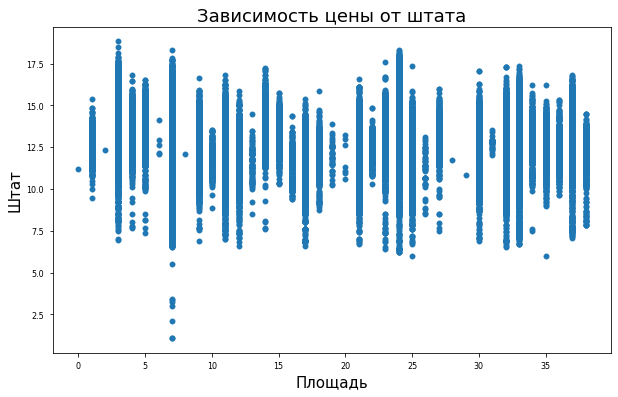

In [360]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Штат', fontsize = 15)
plt.title('Зависимость цены от штата', fontsize = 18)

# Улица

In [361]:
data_d['street'].nunique()

333715

Уникальных значений улиц слишком много. Признак удалила.

 # Stories (надеюсь, это этажи)

In [362]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [363]:
data_d['stories'].isna().sum()

0

<AxesSubplot:xlabel='stories', ylabel='Density'>

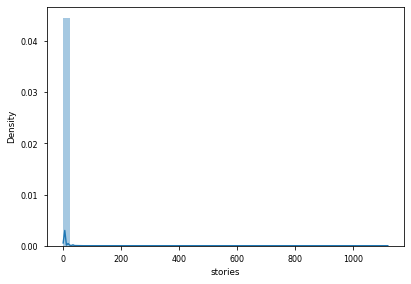

In [364]:
sns.distplot(data_d['stories'])

In [365]:
data_d.loc[data_d['stories']>17]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat
612,for sale,NaN,condo,600 NE 36th St #519,2.0,"[1973, 2005, Forced Air, Central, Attached Gar...",0,Miami,"{'rating': ['2/10', '4/10', '10/10', '2/10', '...",757.0,33137,1,FL,22.0,NaN,NaN,A10584822,12.409013,1964,,,,,—,$406 / Sq. Ft.,"['2', 'NR', '6', 'NR', '4']","['0.3 mi', '0.5 mi', '0.3 mi', '0.5 mi', '2.4 ...","['Preschool to 5', 'Preschool to 8', '6 to 8',...","['Amidon-Bowen Elementary School', 'Waterfront...",0,0,0,61,7
977,for sale,NaN,condo,480 NE 31st St #605,3.0,"[2018, , Forced Air, Central, Attached Garage,...",0,Miami,"{'rating': ['2/10', '4/10', '10/10', '2/10', '...",1322.0,33137,2,FL,54.0,NaN,yes,A10671072,13.814510,1987,,,Central,Attached Garage,0.77 acres,$598/sqft,"['5/10', '8/10', '6/10']","['1.22mi', '0.91mi', '0.28mi']","['9-12', '6-8', 'K-5']","['Forest Hills High School', 'Jhs 190 Russell ...",0,0,0,61,7
988,NaN,NaN,condo,2910 W Barcelona St # 1004,4.0,"[2019, None, Forced air, Central, 2 spaces, No...",0,Tampa,"{'rating': ['9/10', '9/10', '8/10'], 'data': {...",2301.0,33629,1,FL,23.0,NaN,Yes,"1004, Tampa, FL 33629",14.274832,1960,1992,Forced air,,1 space,"6,969 sqft",,"['3/10', '2/10', '3/10']","['0.6 mi', '0.8 mi', '2.3 mi']","['PK-6', '7-9', '9-12']","['Academy Park School', 'John F. Kennedy Jr Hi...",1,0,0,116,7
1170,for sale,NaN,other,2550 Olinville Ave #2A,1.0,"[1999, , Oil, Central, , 2.24 acres, $263/sqft]",0,Bronx,"{'rating': ['5/10', '7/10', '3/10'], 'data': {...",950.0,10467,2,NY,18.0,NaN,NaN,5104665,12.429216,1983,1983,Other,Central,,9.84 acres lot,$167,"['9/10', '1/10', '7/10']","['1.1 mi', '3 mi', '3.6 mi']","['PK-5', '6-8', '9-12']","['Roberts Elementary School', 'Cullen Middle S...",0,0,5,7,24
1276,for sale,NaN,other,357 E 57th St #9G,1.0,"[1958, , , , , 8,183 sqft, $998/sqft]",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '1...",500.0,10022,1,NY,21.0,NaN,NaN,NaN,13.120361,1990,,,,1 space,,,"['8/10', '7/10', '7/10']","['0.2 mi', '0.4 mi', '1.2 mi']","['K-6', '7-8', '9-12']","['Stanford Elementary School', 'Alamitos Inter...",0,0,5,67,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374845,Active,NaN,ctmp,600 Wall St #3405,1.0,"[2020, , , Heat Pump, High Efficiency, Hot Wat...",0,Seattle,"{'rating': ['2', '6'], 'data': {'Distance': ['...",1135.0,98121,1,WA,40.0,NaN,NaN,1498559,14.360709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,104,37
375139,for sale,NaN,condo,45 Park Ave #1503,3.0,"[2008, , , Central, Attached Garage, , $1,594/...",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '9...",1440.0,10016,2,NY,22.0,NaN,NaN,3967902,14.646243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,67,24
375325,NaN,NaN,condo,55 SE 6th St APT 3610,2.0,"[2008, 2008, Forced air, Central, 1 space, Non...",0,Miami,"{'rating': ['10/10', '2/10'], 'data': {'Distan...",1200.0,33131,1,FL,43.0,NaN,NaN,A10730974,13.120361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,61,7
376531,for sale,NaN,condo,75 Wall St #38M,2.0,"[1987, 2008, Forced Air, Central, Attached Gar...",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '9...",1080.0,10005,2,NY,36.0,NaN,NaN,1830955,14.375126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,67,24


In [366]:
data_d = data_d[data_d['stories']<17]

In [367]:
x = data_d['stories']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от этажа')

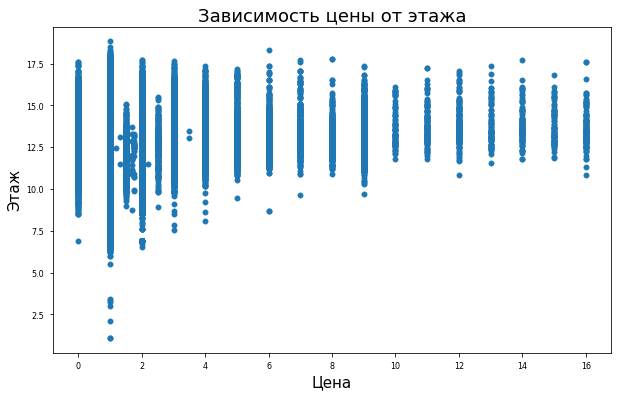

In [368]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Этаж', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

 # Status

In [369]:
data_d['status'].value_counts()

for sale                   154625
Active                     104785
For sale                    43137
foreclosure                  5664
New construction             5453
                            ...  
Coming soon: Nov 8.             1
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Coming soon: Dec 23.            1
Name: status, Length: 156, dtype: int64

In [370]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [371]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [372]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [373]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [374]:
data_d['status'].value_counts()

for_sale                 197762
actv                     106130
nan                       39082
frcls                      9287
cnstr                      5453
pnd                        5347
cntrct                     3073
p                          1488
cntgs                       991
 / auction                  799
new                         689
price change                563
auction                     492
for rent                    397
foreclosed                  294
back on market              112
cmg_s                       110
c                            39
pi                           36
listing extended             28
due diligence period         27
c continue show              18
condo for rent                7
apartment for rent            7
closed                        5
ct                            5
accepted offer                4
pf                            4
for sale                      2
accepting backups             2
ps                            2
uc conti

Приведение к численному виду.

In [375]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes
data_d['status_cat'] = data_d['status_cat'].astype('category')

In [376]:
data_d['status_cat'].isna().sum()

0

In [377]:
x = data_d['status_cat']
y = data_d['target']


Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

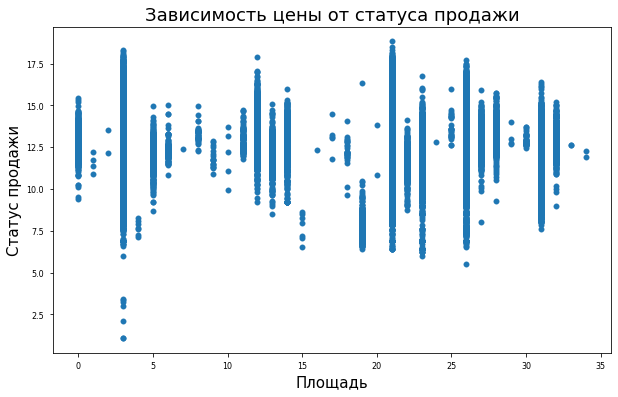

In [378]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Статус продажи', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

# Индекс

In [379]:
data_d['zipcode'].value_counts()

32137         2139
33131         1531
34747         1454
78245         1383
34759         1333
              ... 
43065            1
27604-6105       1
27603-1994       1
50439            1
44704            1
Name: zipcode, Length: 4537, dtype: int64

In [380]:
data_d.zipcode = data_d.zipcode.apply(lambda x: (str(x))[0:2])

In [381]:
data_d.loc[data_d['zipcode']=='--']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat
231282,cnstr,NaN,other,0 N Gopher Canyon Rd,1.0,"[, , , , , , ]",0,others,"{'rating': ['7/10', '7/10', '3/10'], 'data': {...",2100.0,--,1,CA,1.0,OC19261036,NaN,NaN,17.909855,1991,2007,Forced Air,None,Attached Garage,"7,200 sqft",$191/sqft,"['3/10', '1/10', '3/10']","['0.73mi', '0.69mi', '0.53mi']","['K-5', '9-12', '6-8']","['Bryn Mawr Elementary School', 'Renton Senior...",0,0,5,124,3,12
235207,nan,NaN,twnh,1744 N Dixie Hwy # 1744,3.0,"[2010, None, Forced air, Central, No Data, No ...",0,Fort Lauderdale,"{'rating': ['3/10', '5/10', '7/10'], 'data': {...",2043.0,--,1,FL,1.0,NaN,NaN,"1744, Fort Lauderdale, FL",12.959844,1962,,Forced Air,Central,Detached Garage,0.88 acres,$84/sqft,"['5/10', '7/10', '6/10']","['1.51mi', '1.74mi', '1.55mi']","['PK-5', '6-8', '9-12']","['Minglewood Elementary School', 'New Providen...",0,0,7,31,7,26


In [382]:
data_d['zipcode'].value_counts()

33    70863
77    32444
32    27974
78    24752
37    15350
      ...  
0         3
--        2
35        1
58        1
00        1
Name: zipcode, Length: 78, dtype: int64

In [383]:
data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)
data_d = data_d.drop(data_d[data_d['zipcode']=='0'].index)
#data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)

In [384]:
data_d.zipcode = data_d.zipcode.apply(lambda x: int(x))

In [385]:
data_d['zipcode'].value_counts()

33    70863
77    32444
32    27974
78    24752
37    15350
      ...  
59        8
42        7
35        1
58        1
0         1
Name: zipcode, Length: 76, dtype: int64

In [386]:
data_d['zipcode'].isna().sum()

0

In [387]:
data_d['zipcode'] = data_d['zipcode'].astype('category')

In [388]:
x = data_d['zipcode']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от индекса')

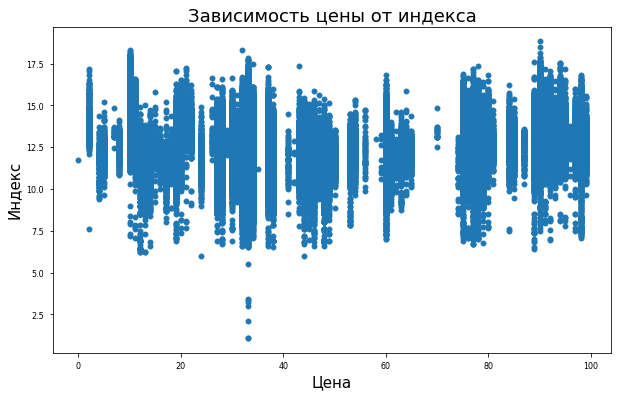

In [389]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Индекс', fontsize = 15)
plt.title('Зависимость цены от индекса', fontsize = 18)

# Разбор нового признака - рейтинг школы

Вспомогательная функция - возвращает численный список: численное значение рейтинга, если рейтинг выражен числом, первое значение дроби или ноль, если встречаются любые другие символы.

In [390]:
data_d['typeRating']=data_d['rating'].apply(lambda x: type(x))

In [391]:
data_d['typeRating'].value_counts()

<class 'str'>      369793
<class 'float'>      2462
Name: typeRating, dtype: int64

In [392]:
data_d.rating=data_d.rating.apply(lambda x: '[]' if type(x)==float else x)

In [393]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,12.943237,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,12.644328,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,14.878496,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"['8/10', '4/10', '8/10']","['1.19mi', '2.06mi', '2.63mi']","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>
3,for_sale,NaN,other,4311 Livingston Ave,8.0,"[2006, 2006, Forced Air, Central, Detached Gar...",1,Dallas,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",2301.0,75,5,TX,3.0,NaN,NaN,14191809,14.688894,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"['9/10', '9/10', '10/10', '9/10']","['1.05mi', '0.1mi', '1.05mi', '0.81mi']","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield E...",1,0,5,20,33,21,<class 'str'>


In [394]:
data_d.rating=data_d.rating.apply(lambda x: eval(x))

In [395]:
def school_rating1 (lst_r):
    lst_clean = []
    for p in lst_r:
        if p.find('/') == -1:
            if p.isdigit():
                lst_clean.append(int(p))
            else: lst_clean.append(0)
        else:
            num = p[:p.find('/')]
            if num.isdigit():
                lst_clean.append(int(num))
                
            else: lst_clean.append(0)

    return lst_clean

In [396]:
data_d.rating = data_d.rating.apply(lambda x: school_rating1(x))

In [397]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372255 entries, 0 to 377184
Data columns (total 36 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            372255 non-null  category
 1   private pool      4113 non-null    object  
 2   propertyType      372255 non-null  category
 3   street            372253 non-null  object  
 4   baths             372255 non-null  float64 
 5   homeFacts         372255 non-null  object  
 6   fireplace         372255 non-null  int64   
 7   city              372255 non-null  category
 8   schools           372255 non-null  object  
 9   sqft              372255 non-null  float64 
 10  zipcode           372255 non-null  category
 11  beds              372255 non-null  int64   
 12  state             372255 non-null  category
 13  stories           372255 non-null  float64 
 14  mls-id            24842 non-null   object  
 15  PrivatePool       39251 non-null   object  
 16  Ml

# Создание новых признаков: маскимальный рейтинг, средний рейтинг.

In [398]:
data_d['max_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else max(x))

In [399]:
data_d['mean_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [400]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,12.943237,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>,7,3.25
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,12.644328,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>,4,2.67
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,14.878496,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8, 4, 8]","['1.19mi', '2.06mi', '2.63mi']","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>,8,6.67


# Разбор нового признака расстояние

Вспомогательная функция возвращает список числовых значений расстояния

In [401]:
data_d.Distance=data_d.Distance.apply(lambda x: '[]' if type(x)==float else x)

In [402]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [403]:
data_d['type_Dist'].value_counts()

<class 'str'>    372255
Name: type_Dist, dtype: int64

In [404]:
data_d.Distance = data_d.Distance.apply(lambda x: eval(x))

In [405]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [406]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,12.943237,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,12.644328,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65mi, 1.32mi, 1.01mi]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>,4,2.67,<class 'list'>
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,14.878496,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8, 4, 8]","[1.19mi, 2.06mi, 2.63mi]","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>,8,6.67,<class 'list'>
3,for_sale,NaN,other,4311 Livingston Ave,8.0,"[2006, 2006, Forced Air, Central, Detached Gar...",1,Dallas,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",2301.0,75,5,TX,3.0,NaN,NaN,14191809,14.688894,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"[9, 9, 10, 9]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield E...",1,0,5,20,33,21,<class 'str'>,10,9.25,<class 'list'>


In [407]:
data_d['typeRating'].value_counts()

<class 'str'>      369793
<class 'float'>      2462
Name: typeRating, dtype: int64

In [408]:
def distance_select(distance):
    lst_dist = []
    if distance == []: return []
    else:
        for i in distance:
            if i.find(' mi')>-1:
                lst_dist.append(float(i[:-3]))
            elif i.find('mi')>-1:
                lst_dist.append(float(i[:-2]))
            else: lst_dist.append(0)
    return lst_dist

In [409]:
data_d.Distance = data_d.Distance.apply(lambda x: distance_select(x))

In [410]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,12.943237,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,12.644328,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>,4,2.67,<class 'list'>
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,14.878496,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8, 4, 8]","[1.19, 2.06, 2.63]","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>,8,6.67,<class 'list'>
3,for_sale,NaN,other,4311 Livingston Ave,8.0,"[2006, 2006, Forced Air, Central, Detached Gar...",1,Dallas,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",2301.0,75,5,TX,3.0,NaN,NaN,14191809,14.688894,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"[9, 9, 10, 9]","[1.05, 0.1, 1.05, 0.81]","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield E...",1,0,5,20,33,21,<class 'str'>,10,9.25,<class 'list'>


# Добавление новых признаков: минимальное расстояние до школы, среднее расстояние до школы.

In [411]:
data_d['min_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else min(x))
data_d['mean_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

# Выделение нового признака - цена за квадратный метр.

In [412]:
data_d['price_sqft'].isna().sum()

58922

In [413]:
def price_clean(price):
    
    if price == None: return np.NaN
    
    elif type(price) == float: return price

    elif price.find('$')>-1: return price_clean(price[1:])
   
    elif price.find('/')>-1: return price_clean(price[0:price.find('/')])
    
    elif price.isnumeric(): return float(price)
    
    else: return np.NaN

In [414]:
data_d.price_sqft = data_d.price_sqft.apply(lambda x: price_clean(x))

In [415]:
data_d['price_sqft'].isna().sum()

121984

# Для модели, построенной для цены за квадратный метр, заполнение убрать.

# Модель с целевой переменной цена за кв. метр.

In [416]:
#data_d[['price_sqft']] = data_d[['price_sqft']].fillna(data_d['price_sqft'].median())

In [417]:
data_d['price_sqft'].isna().sum()

121984

In [418]:
data_d = data_d.dropna(axis=0,subset=['price_sqft'])

In [419]:
data_d['price_sqft'].isna().sum()

0

# Выбор предварительного датафрейма для модели

In [420]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250271 entries, 0 to 374688
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            250271 non-null  category
 1   private pool      2754 non-null    object  
 2   propertyType      250271 non-null  category
 3   street            250270 non-null  object  
 4   baths             250271 non-null  float64 
 5   homeFacts         250271 non-null  object  
 6   fireplace         250271 non-null  int64   
 7   city              250271 non-null  category
 8   schools           250271 non-null  object  
 9   sqft              250271 non-null  float64 
 10  zipcode           250271 non-null  category
 11  beds              250271 non-null  int64   
 12  state             250271 non-null  category
 13  stories           250271 non-null  float64 
 14  mls-id            16648 non-null   object  
 15  PrivatePool       26250 non-null   object  
 16  Ml

In [421]:
columns = data_d.columns

In [422]:
columns = columns.tolist()

In [423]:
columns

['status',
 'private pool',
 'propertyType',
 'street',
 'baths',
 'homeFacts',
 'fireplace',
 'city',
 'schools',
 'sqft',
 'zipcode',
 'beds',
 'state',
 'stories',
 'mls-id',
 'PrivatePool',
 'MlsId',
 'target',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'price_sqft',
 'rating',
 'Distance',
 'Grades',
 'name',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'typeRating',
 'max_rating',
 'mean_rating',
 'type_Dist',
 'min_distance',
 'mean_distance']

In [424]:
lst_remove = ['status','mls-id','private pool',
 'PrivatePool','Year built','state',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'MlsId','propertyType','street','homeFacts','city','schools','rating',
 'Distance',
 'Grades',
 'name','typeRating',
 'type_Dist','target']

In [425]:
columns = columns
lst_remove = lst_remove
for i in lst_remove:
    columns.remove(i)

In [426]:
columns

['baths',
 'fireplace',
 'sqft',
 'zipcode',
 'beds',
 'stories',
 'price_sqft',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'max_rating',
 'mean_rating',
 'min_distance',
 'mean_distance']

In [427]:
data_d_preliminary=data_d[columns]

In [428]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250271 entries, 0 to 374688
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   baths             250271 non-null  float64 
 1   fireplace         250271 non-null  int64   
 2   sqft              250271 non-null  float64 
 3   zipcode           250271 non-null  category
 4   beds              250271 non-null  int64   
 5   stories           250271 non-null  float64 
 6   price_sqft        250271 non-null  float64 
 7   sqft_big          250271 non-null  int64   
 8   beds_big          250271 non-null  int64   
 9   propertyType_cat  250271 non-null  category
 10  city_cat          250271 non-null  category
 11  state_cat         250271 non-null  category
 12  status_cat        250271 non-null  category
 13  max_rating        250271 non-null  int64   
 14  mean_rating       250271 non-null  float64 
 15  min_distance      250271 non-null  float64 
 16  me

In [429]:
data_d_preliminary.isna().sum()

baths               0
fireplace           0
sqft                0
zipcode             0
beds                0
stories             0
price_sqft          0
sqft_big            0
beds_big            0
propertyType_cat    0
city_cat            0
state_cat           0
status_cat          0
max_rating          0
mean_rating         0
min_distance        0
mean_distance       0
dtype: int64

# Визуализация

(12.5, -0.5)

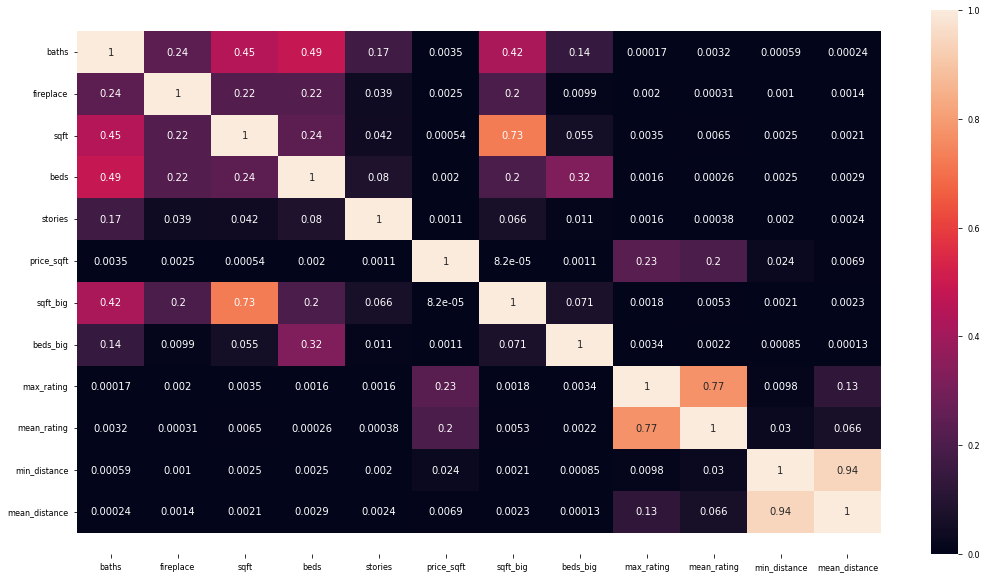

In [430]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Нормализация

In [431]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [432]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [433]:
# data_d_preliminaty_n

In [434]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Подготовка данных для модели.

In [435]:
columns = data_d_preliminary.columns
columns = columns.tolist()
columns.remove('price_sqft')

In [436]:
columns

['baths',
 'fireplace',
 'sqft',
 'zipcode',
 'beds',
 'stories',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'max_rating',
 'mean_rating',
 'min_distance',
 'mean_distance']

In [437]:
X=data_d_preliminary[columns]

In [438]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250271 entries, 0 to 374688
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   baths             250271 non-null  float64 
 1   fireplace         250271 non-null  int64   
 2   sqft              250271 non-null  float64 
 3   zipcode           250271 non-null  category
 4   beds              250271 non-null  int64   
 5   stories           250271 non-null  float64 
 6   sqft_big          250271 non-null  int64   
 7   beds_big          250271 non-null  int64   
 8   propertyType_cat  250271 non-null  category
 9   city_cat          250271 non-null  category
 10  state_cat         250271 non-null  category
 11  status_cat        250271 non-null  category
 12  max_rating        250271 non-null  int64   
 13  mean_rating       250271 non-null  float64 
 14  min_distance      250271 non-null  float64 
 15  mean_distance     250271 non-null  float64 
dtypes:

In [439]:
X.isna().sum()

baths               0
fireplace           0
sqft                0
zipcode             0
beds                0
stories             0
sqft_big            0
beds_big            0
propertyType_cat    0
city_cat            0
state_cat           0
status_cat          0
max_rating          0
mean_rating         0
min_distance        0
mean_distance       0
dtype: int64

In [440]:
y = data_d_preliminary[['price_sqft']]

In [441]:
y.isna().sum()

price_sqft    0
dtype: int64

In [442]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

# Тестирование моделей

In [443]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [444]:
def grafik(y_test,y_pred):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, linewidth=1, label="original")
    plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
    plt.title("y-test and y-predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

# Линейная регрессия

In [445]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)




In [448]:
y_pred = np.power(y_pred,np.e)
y_pred

array([[1.73848028e+18],
       [2.79563271e+16],
       [2.36540834e+17],
       ...,
       [1.61991940e+18],
       [4.02313899e+17],
       [5.22284124e+16]])

In [449]:
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
grafik(y_test,y_pred)

# Случайный лес

In [450]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)
model.fit(X_train, y_train) # обучение
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 


R-squared: 0.8682154737836649


In [451]:
y_pred = model.predict(X_test)
y_pred = np.power(y_pred,np.e)
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 4712259.746482176
RMSE: 8830144.443184853
R2: -2531559322.42


In [ ]:
grafik(y_test,y_pred)

# Регрессия с дополнительными деревьями

In [452]:
model = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
predict_extra_tree = model.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
#print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


[278848  98589 323930 ... 123342 294502 156180]


In [453]:
y_pred = model.predict(X_test)
y_pred = np.power(y_pred,np.e)
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 4417717.292514598
RMSE: 8022226.109010185
R2: -2089499589.56


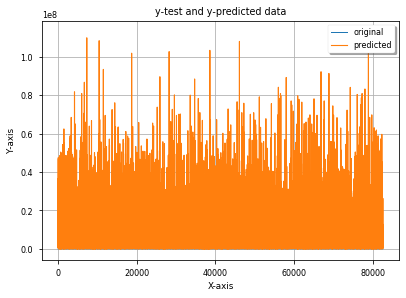

In [454]:
grafik(y_test,y_pred)

# Катбуст

In [455]:
cat_features = ['zipcode','propertyType_cat','state_cat','city_cat','status_cat']

In [456]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         cat_features = cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 164.0983374	test: 163.9293055	best: 163.9293055 (0)	total: 449ms	remaining: 7m 28s
100:	learn: 140.0577351	test: 150.7817017	best: 150.4589803 (72)	total: 31.8s	remaining: 4m 42s
200:	learn: 131.3552070	test: 150.6646142	best: 150.4336000 (132)	total: 1m 3s	remaining: 4m 13s
300:	learn: 124.4358778	test: 151.1128114	best: 150.4336000 (132)	total: 1m 36s	remaining: 3m 43s
400:	learn: 118.8509956	test: 151.7936017	best: 150.4336000 (132)	total: 2m 9s	remaining: 3m 12s
500:	learn: 113.8408022	test: 152.5585072	best: 150.4336000 (132)	total: 2m 42s	remaining: 2m 42s
600:	learn: 109.2886539	test: 153.1248291	best: 150.4336000 (132)	total: 3m 15s	remaining: 2m 10s
700:	learn: 105.0582502	test: 153.7362255	best: 150.4336000 (132)	total: 3m 50s	remaining: 1m 38s
800:	learn: 100.9215358	test: 154.2237810	best: 150.4336000 (132)	total: 4m 23s	remaining: 1m 5s
900:	learn: 97.6592258	test: 154.7215737	best: 150.4336000 (132)	total: 4m 57s	remaining: 32.7s
999:	learn: 94.4299315	test: 155

In [457]:
y_pred = catboost.predict(X_test)
y_pred = np.power(y_pred,np.e)
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
grafik(y_test,y_pred)

Ридж

In [458]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

In [459]:
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(X_train, y_train)
print(ridge_regression.predict(X_test))
print(ridge_regression.score(X_test, y_test))

[[294.12946802]
 [168.18569825]
 [224.54452584]
 ...
 [291.33119959]
 [241.27856216]
 [183.03016497]]
0.05610620887747464


In [460]:
y_pred = ridge_regression.predict(X_test)
y_pred = np.power(y_pred,np.e)
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
grafik(y_test,y_pred)

Лассо

In [461]:
from sklearn.linear_model import Lasso

In [462]:
lasso_regression = Lasso(alpha=0.1)
lasso_regression.fit(X_train, y_train)
print(lasso_regression.predict(X_test))
print(lasso_regression.score(X_test, y_test))

[293.82621416 168.55440911 224.50216643 ... 291.95130879 241.25475251
 183.23229733]
0.05612895127748241


In [463]:
y_pred = lasso_regression.predict(X_test)
y_pred = np.power(y_pred,np.e)
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
grafik(y_test,y_pred)

Градиентный бустинг

In [464]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)

GradientBoostingRegressor()

In [465]:
y_pred = gradient_boosting.predict(X_test)
y_pred = np.power(y_pred,np.e)
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 3381694.5316027165
RMSE: 4803215.017004868
R2: -749059902.0


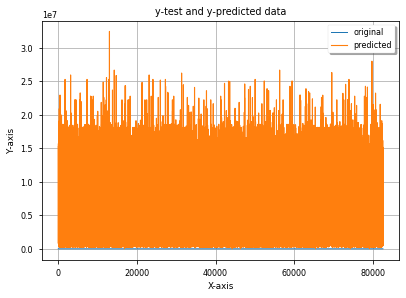

In [466]:
grafik(y_test,y_pred)

# Анализ feature importance

Feature: 0, Score: -0.46310
Feature: 1, Score: -1.29003
Feature: 2, Score: 0.00069
Feature: 3, Score: -0.02467
Feature: 4, Score: 0.40005
Feature: 5, Score: -0.13875
Feature: 6, Score: 0.43606
Feature: 7, Score: -7.06103
Feature: 8, Score: -0.21261
Feature: 9, Score: 0.01121
Feature: 10, Score: 0.03498
Feature: 11, Score: -0.00551
Feature: 12, Score: 14.40858
Feature: 13, Score: 3.97552
Feature: 14, Score: -2.08080
Feature: 15, Score: 1.06801


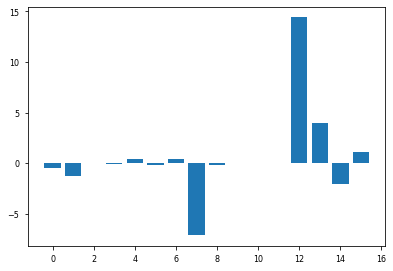

In [467]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Text(0.5, 1.0, 'Feature Importance')

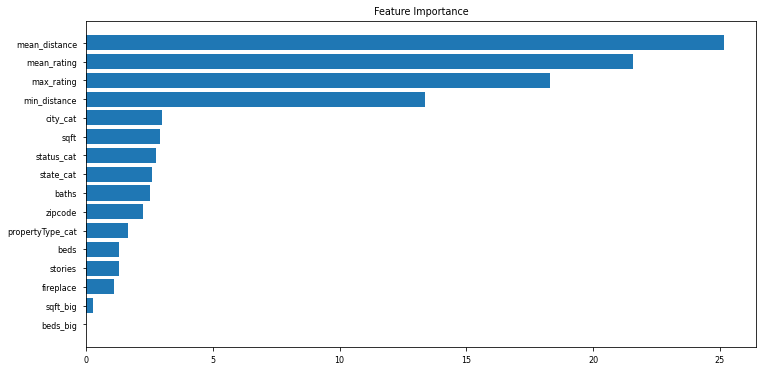

In [468]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')